In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 40
img_height = 224
img_width = 224

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [3]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [4]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [5]:
training_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = training_ds.class_names

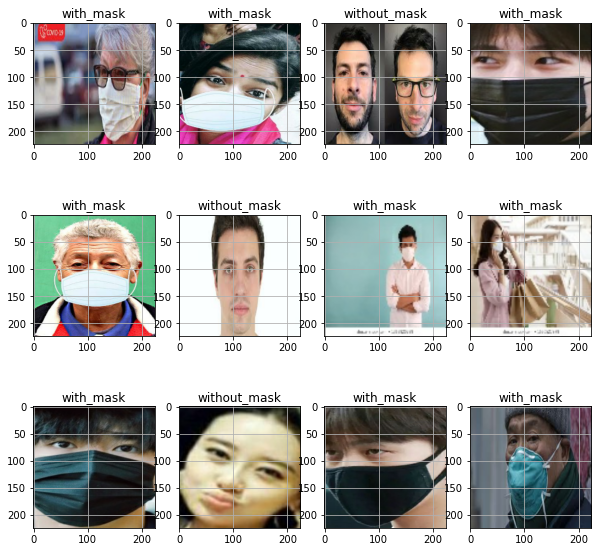

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [8]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

Import Resnet50 Model

In [9]:
from keras.applications import InceptionV3
from tensorflow.keras.layers import Input
from keras.models       import Model
from keras.layers import Dense
import keras
from sklearn.preprocessing import LabelEncoder
from numpy import array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

### Build a model from Resnet50

In [10]:
resnet50 = keras.applications.resnet50.ResNet50(include_top=True)

In [11]:
# first freeze all the resnet layers so they can't be trained
for layer in resnet50.layers:
    layer.trainable=False

# index -2 is the penultimate layer.
embedding_layer = resnet50.get_layer(index=-2)
embedding_layer_out = embedding_layer.output
embedding_layer

In [12]:
resnet50_input = resnet50.input
new_classification_output = Dense(1, activation='sigmoid')(embedding_layer_out)
new_model = Model(inputs=resnet50_input, outputs=new_classification_output)

#new_model.summary()

### I only did three epochs due to lack of computing power for my model...it still took 2 hrs and 13 minutes

In [13]:
#f1 = (2*(keras.metrics.Precision()*keras.metrics.Recall())/(keras.metrics.Precision()+keras.metrics.Recall()))
new_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'
                      , keras.metrics.Recall(), keras.metrics.Precision(), keras.metrics.TruePositives()
                      , keras.metrics.FalsePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives()
                      ])
history = new_model.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=3,
  use_multiprocessing=True
)

Epoch 1/3
152/152 [==============================] - 992s 7s/step - loss: 0.1209 - accuracy: 0.9626 - recall: 0.9562 - precision: 0.9695 - true_positives: 2926.0000 - false_positives: 92.0000 - true_negatives: 2891.0000 - false_negatives: 134.0000 - val_loss: 0.0581 - val_accuracy: 0.9801 - val_recall: 0.9648 - val_precision: 0.9960 - val_true_positives: 741.0000 - val_false_positives: 3.0000 - val_true_negatives: 739.0000 - val_false_negatives: 27.0000
Epoch 2/3
152/152 [==============================] - 800s 5s/step - loss: 0.0423 - accuracy: 0.9884 - recall: 0.9863 - precision: 0.9908 - true_positives: 3018.0000 - false_positives: 28.0000 - true_negatives: 2955.0000 - false_negatives: 42.0000 - val_loss: 0.0394 - val_accuracy: 0.9861 - val_recall: 0.9766 - val_precision: 0.9960 - val_true_positives: 750.0000 - val_false_positives: 3.0000 - val_true_negatives: 739.0000 - val_false_negatives: 18.0000
Epoch 3/3
152/152 [==============================] - 882s 6s/step - loss: 0.0300 - ac

In [18]:
n_epochs = 3
f1_train = (2*(history.history['recall'][n_epochs - 1]*history.history['precision'][n_epochs - 1])/(history.history['recall'][n_epochs - 1]+history.history['precision'][n_epochs - 1]))
f1_test = (2*(history.history['val_recall'][n_epochs - 1]*history.history['val_precision'][n_epochs - 1])/(history.history['val_recall'][n_epochs - 1]+history.history['val_precision'][n_epochs - 1]))

In [19]:
print(f1_train)
print(f1_test)

0.9923089379440656
0.9901639309230841


In [20]:
print(history.history['accuracy'])
print(history.history['val_accuracy'])

print(history.history['loss'])
print(history.history['val_loss'])

[0.962601363658905, 0.9884163737297058, 0.9922224283218384]
[0.9801324605941772, 0.9860926866531372, 0.9900662302970886]
[0.1209297627210617, 0.042294491082429886, 0.03002830408513546]
[0.058071136474609375, 0.03944456949830055, 0.032245781272649765]


In [31]:
print("      Train ")
print(f"   | True   | False")
print(f"1  | {history.history['true_positives'][2]} | {history.history['false_positives'][2]}" )
print(f"0  | {history.history['false_negatives'][2]}   | {history.history['true_negatives'][2]}")

      Train 
   | True   | False
1  | 3032.0 | 19.0
0  | 28.0   | 2964.0


In [33]:
print("      Test ")
print(f"   | True  | False")
print(f"1  | {history.history['val_true_positives'][2]} | {history.history['val_false_positives'][2]}" )
print(f"0  | {history.history['val_false_negatives'][2]}  | {history.history['val_true_negatives'][2]}")

      Test 
   | True  | False
1  | 755.0 | 2.0
0  | 13.0  | 740.0


In [39]:
ypred = new_model.predict(testing_ds)
ypred = np.where(ypred > 0.5, 1, 0)

In [40]:
ytrue = [y for x, y in testing_ds]
ytrue = np.concatenate(ytrue)
from sklearn import metrics
metrics.confusion_matrix(ytrue, ypred)

array([[740,   2],
       [ 13, 755]])

New images

In [35]:
mask_url = "https://media.vanityfair.com/photos/5f2ac1b683d239dce41f8229/master/pass/kate-middleton.jpg"
mask_path = tf.keras.utils.get_file('kate mask', origin=mask_url)

img = keras.preprocessing.image.load_img(
    mask_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


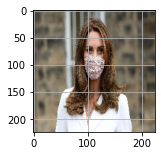

In [36]:
plt.figure(figsize=(10, 10)) 
ax = plt.subplot(3, 4, 1)
plt.imshow(img)
#plt.title()
plt.grid(True)

In [37]:
pink_url = "https://cdn.shopify.com/s/files/1/2727/4444/products/E42A9819.jpg?v=1586730354"
pink_path = tf.keras.utils.get_file('pink', origin=pink_url)

img = keras.preprocessing.image.load_img(
    pink_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


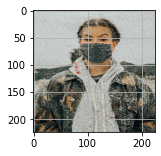

In [38]:
plt.figure(figsize=(10, 10)) 
ax = plt.subplot(3, 4, 1)
plt.imshow(img)
#plt.title()
plt.grid(True)